# Explainable Multivariate Deep Transformer for Stock Prediction

# Library

In [1]:
import torch
from torch import nn, einsum
import torch.optim as optim
import torch.nn.functional as F
import math
from functools import partial
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os
import random
from torch.autograd import Variable
import time

# Deep Transformer

## Model

### Full Attention

In [2]:
def full_attention(query, key, value, causal=False, dropout=0.0):
    device = key.device
    B_k, h_k, n_k, d_k = key.shape
    B_q, h_q, n_q, d_q = query.shape

    scale = einsum("bhqd,bhkd->bhqk", query, key)/math.sqrt(d_k)

    if causal:
        ones = torch.ones(B_k, h_k, n_q, n_k).to(device)
        mask = torch.tril(ones)
        scale = scale.masked_fill(mask == 0, -1e9)
    atn = F.softmax(scale, dim=-1)
    if dropout is not None:
        atn = F.dropout(atn, p=dropout)   
    out = einsum("bhqk,bhkd->bhqd", atn, value)
    return out

In [3]:
def to_eachhead(x, head_num, split_num=3):
    B, n, pre_d = x.shape
    new_d = pre_d//split_num
    assert pre_d%split_num == 0, f"have to be multiple of {split_num}"
    assert new_d%head_num == 0, "dim must be divided by head_num"

    tpl = torch.chunk(x, split_num, dim=2)
    out = []
    for t in tpl:
        out.append(t.reshape(B, n, head_num, new_d//head_num).transpose(1,2))
    return out

In [4]:
def concat_head(x):
    B, h, n, _d = x.shape
    out = x.transpose(1,2).reshape(B, n, _d*h)
    return out

### Positional Encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.squeeze(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

### Pre-Layer

In [6]:
class PreLayer(nn.Module):
    def __init__(self, hid, d_model, drop_out=0.0, in_dim=1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hid, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid, d_model, bias=True)
    
    def forward(self, x):
        out_1 = self.linear1(x)
        out = self.relu(out_1)
        out = self.linear2(out)
        return out, out_1

### Post-Layer

In [7]:
class PostLayer(nn.Module):
    def __init__(self, d_model, vocab_num, hid, drop_out=0.0):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hid, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid, vocab_num, bias=True)
    
    def forward(self, x):
        out_1 = self.linear1(x)
        out_relu = self.relu(out_1)
        out = self.linear2(out_relu)
        return out,out_1

### Multi-Head Attention

#### Multi-Head Self Attention

In [8]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_qvk = nn.Linear(dim, dim*3)
        self.make_head = partial(to_eachhead, head_num=head_num, split_num=3)
        self.mhsa = full_attention
    
    def forward(self, x):
        qvk = self.to_qvk(x)
        q, v, k = self.make_head(qvk)
        out = self.mhsa(q, k, v)
        out = concat_head(out)
        return out

#### Multi-Head Causal Attention

In [9]:
class MultiHeadCausalAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_qvk = nn.Linear(dim, dim*3)
        self.make_head = partial(to_eachhead, head_num=head_num, split_num=3)
        self.mhca = partial(full_attention, causal=True)

    def forward(self, x):
        qvk = self.to_qvk(x)
        q, v, k = self.make_head(qvk)
        out = self.mhca(q, k, v)
        out = concat_head(out)
        return out

#### Multi-Head Source Attention

In [10]:
class MultiHeadSourceAttention(nn.Module):
    def __init__(self, dim, head_num):
        super().__init__()
        self.to_kv = nn.Linear(dim, dim*2)
        self.to_q = nn.Linear(dim, dim)
        self.make_head_kv = partial(to_eachhead, head_num=head_num, split_num=2)
        self.make_head_q = partial(to_eachhead, head_num=head_num, split_num=1)
        self.mhsa = full_attention

    def forward(self, x, memory):
        mem = self.to_kv(memory)
        x = self.to_q(x)
        k, v = self.make_head_kv(mem)
        q = self.make_head_q(x)[0]
        out = self.mhsa(q, k, v)
        out = concat_head(out)
        return out

### Feed Forward

In [11]:
class FeedForward(nn.Module):
    def __init__(self, dim, hid_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, hid_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hid_dim, dim, bias=True)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

### Encoder

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, dim, head_num, ff_hidnum, dropout_ratio, norm_first=False):
        super().__init__()
        self.dor = dropout_ratio
        self.mhsa = MultiHeadSelfAttention(dim, head_num)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, ff_hidnum)
        self.ln2 = nn.LayerNorm(dim)
        self.norm_first = norm_first

    def forward(self, x):
        res = torch.clone(x)

        if self.norm_first:
          out = self.ln1(x)
          out = self.mhsa(out)
          out = F.dropout(out, p=self.dor) + res

          res = torch.clone(out)
          out = self.ln2(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
        else:
          out = self.mhsa(x)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln1(out)

          res = torch.clone(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln2(out)

        return out

In [13]:
class Encoder(nn.Module):
    def __init__(self, depth, dim, head_num, ff_hidnum=2048, dropout_ratio=0.2, norm_first=False):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(dim, head_num, ff_hidnum, dropout_ratio, norm_first) for i in range(depth)])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Decoder

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, dim, head_num, ff_hidnum, dropout_ratio, norm_first=False):
        super().__init__()
        self.dor = dropout_ratio
        self.mhca = MultiHeadCausalAttention(dim, head_num)
        self.ln1 = nn.LayerNorm(dim)
        self.mhsa = MultiHeadSourceAttention(dim, head_num)
        self.ln2 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, ff_hidnum)
        self.ln3 = nn.LayerNorm(dim)
        self.norm_first = norm_first

    def forward(self, x, memory):
        res = torch.clone(x)

        if self.norm_first:
          out = self.ln1(x)
          out = self.mhca(out)
          out = F.dropout(out, p=self.dor) + res
          
          res = torch.clone(out)
          out = self.ln2(out)
          out = self.mhsa(out, memory)
          out = F.dropout(out, p=self.dor) + res

          res = torch.clone(out)
          out = self.ln3(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res

        else:
          out = self.mhca(x)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln1(out)

          res = torch.clone(out)
          out = self.mhsa(out, memory)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln2(out)

          res = torch.clone(out)
          out = self.ff(out)
          out = F.dropout(out, p=self.dor) + res
          out = self.ln3(out)

        return out

In [15]:
class Decoder(nn.Module):
    def __init__(self, depth, dim, head_num, ff_hidnum, dropout_ratio=0.2, norm_first=False):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(dim, head_num, ff_hidnum, dropout_ratio, norm_first) for i in range(depth)])
    
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return x

### Transformer

In [16]:
class Transformer(nn.Module):
    def __init__(self, device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first=False):
        super().__init__()
        self.device = device
        self.x_pre = PreLayer(hid_pre, d_model, dropout_pre, in_dim)
        self.y_pre = PreLayer(hid_pre, d_model, dropout_pre, in_dim)
        self.pos = PositionalEncoding(d_model)
        self.enc = Encoder(N_enc,d_model, h_enc, ff_hidnum, dropout_model, norm_first)
        self.dec = Decoder(N_dec,d_model, h_dec, ff_hidnum, dropout_model, norm_first)
        self.post = PostLayer(d_model,in_dim, hid_post, dropout_post)

    def forward(self, x, y):
        x_emb, x_out = self.x_pre(x)
        y_emb, y_out = self.y_pre(y)
        x_emb_pos = self.pos(x_emb)
        y_emb_pos = self.pos(y_emb)
        memory = self.enc(x_emb_pos)
        out_dec = self.dec(y_emb_pos, memory)
        out_post, out_1 = self.post(out_dec)
        out = out_post.squeeze(-1)
        return out, out_1

    def generate(self, x, forcast_step, y_start,multivariate=False):
        device = x.device
        x = x.to(device)
        B, N, D = x.shape
        x, pre_x = self.x_pre(x) 
        x = self.pos(x)
        z = self.enc(x) 
        y = y_start
        for i in range(forcast_step):
            y_pred, pre_y = self.y_pre(y)
            y_pred = self.pos(y_pred)
            y_pred = self.dec(y_pred, z)
            y_pred, pos = self.post(y_pred)
            if multivariate:
                y = torch.cat([y, y_pred[:,[-1],:]], dim=2)
            else:
                y = torch.cat([y, y_pred[:,[-1],:]], dim=1)
        y_pred = y_pred.squeeze(-1)
        return y_pred

## Grad-CAM

In [17]:
def show_cam_on_image(mask,i):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    cam = heatmap
    cam = cam / np.max(cam)
    
    # np.save('Grad-CAM/cam_array_%s'%(i), cam.transpose(1,0,2))
    # cv2.imwrite("Grad-CAM/transformer%s_fitur.png" %(i), np.uint8(255*cam.transpose(1,0,2)))

In [18]:
class FeatureExtractor():
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
      
        x.register_hook(self.save_gradient)
        outputs += [x]
        return outputs, x

In [19]:
class ModelOutputs():
    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x, cudas=False):
        target_activations = []
        dataiter = iter(x)
        x1, y, tgt = next(dataiter)
        if cudas:
            out, inp = self.model(x1.cuda(),y.cuda())
        else:
            out, inp = self.model(x1,y)

        target_activations, inp = self.feature_extractor(inp) 
        return target_activations, out

In [20]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.train()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, in_dim):
        length = input.dataset.datalen
        if self.cuda:
            features, output = self.extractor(input, cudas=True)
        else:
            features, output = self.extractor(input)
    
        output = output.squeeze()
        # output = 1-output
        one_hot = np.zeros((output.size()[0], output.size()[1]), dtype=np.float32)
        one_hot[:,0] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)

        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()

        one_hot.backward(retain_graph=True)

        weights = self.extractor.get_gradients()[0].cpu().data.numpy()
        weights = np.mean(weights, axis=(1))

        target = features[-1]
        target = target.cpu().data.numpy()
        target = np.mean(target, axis=(1))
        
        cam = weights*(target)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, torch.Size([in_dim,length+4]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

## Dataset

In [105]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, input_step, predict_step):
        super().__init__()
        self.data = data
        self.predict_step = predict_step
        self.input_step = input_step
        self.start_max = self.data.shape[0] - (self.predict_step + self.input_step) + 1
        self.datalen = self.start_max

    def __len__(self):
        return self.datalen

    def __getitem__(self, idx):
        start_idx = idx % self.start_max
        predict_idx = start_idx + self.input_step
        end_idx = predict_idx + self.predict_step

        x = self.data[start_idx:predict_idx, :]
        y = self.data[predict_idx-1:end_idx-1, :]
        tgt = self.data[predict_idx:end_idx, :]


        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        tgt = torch.from_numpy(tgt)

        return x, y, tgt

In [106]:
def load_data(data_path, test_size=30,multivariate=False,in_dim=1):
    data = pd.read_csv(data_path)

    data.date = pd.to_datetime(data.date)

    data = data.set_index('date')
    data_len = data.shape[0]
    numpy_use_jii = data['jii'].to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    numpy_use_jii = scaler.fit_transform(numpy_use_jii.reshape(-1,1))
    if multivariate:
        if in_dim == 10:
            data = data[['jii', 'vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 36:
            data = data.drop(columns=['vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 41:
            data = data.drop(columns=['new_cases', 'new_cases_smoothed', 'new_cases_per_million','new_cases_smoothed_per_million'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 45:
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 8:
            data = data[['jii', 'oil/bbl', 'total_tests', 'total_vaccinations', 'eur', 'total_cases', 'new_tests', 'gas/mmbtu']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 29:
            data = data[['jii', 'silver/gr', 'oil/bbl', 'stringency_index', 'new_deaths_per_million', 'new_tests_smoothed_per_thousand', 'usd', 'vol ihsg', 'ihsg', 'new_tests_per_thousand', 'new_deaths', 'total_cases_per_million', 'new_cases_smoothed_per_million', 'new_deaths_smoothed', 'total_deaths_per_million', 'people_vaccinated_per_hundred', 'new_vaccinations', 'total_deaths', 'people_fully_vaccinated', 'reproduction_rate', 'gas/mmbtu', 'eur', 'new_deaths_smoothed_per_million', 'total_tests', 'new_people_vaccinated_smoothed_per_hundred', 'vol jii', 'new_vaccinations_smoothed', 'new_cases_per_million', 'gold/gr']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 17:
            data = data[['jii','new_people_vaccinated_smoothed_per_hundred', 'eur', 'people_vaccinated', 'total_vaccinations_per_hundred', 'new_vaccinations_smoothed_per_million', 'oil/bbl', 'reproduction_rate', 'people_fully_vaccinated_per_hundred', 'new_deaths_per_million', 'new_cases_smoothed_per_million', 'vol ihsg', 'gas/mmbtu', 'new_tests', 'total_boosters', 'new_vaccinations', 'new_cases_smoothed']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 23:
            data = data[['jii','new_people_vaccinated_smoothed_per_hundred', 'total_vaccinations', 'new_deaths', 'gold/gr', 'oil/bbl', 'people_vaccinated_per_hundred', 'ihsg', 'new_cases_smoothed', 'silver/gr', 'total_deaths_per_million', 'tests_per_case', 'new_deaths_smoothed_per_million', 'usd', 'new_vaccinations', 'total_vaccinations_per_hundred', 'new_tests_per_thousand', 'new_people_vaccinated_smoothed', 'total_tests', 'positive_rate', 'eur', 'people_fully_vaccinated_per_hundred', 'gas/mmbtu']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 15:
            data = data[['jii','total_vaccinations', 'silver/gr', 'new_deaths', 'people_vaccinated', 'new_cases', 'vol jii', 'total_boosters_per_hundred', 'vol ihsg', 'gas/mmbtu', 'usd', 'new_tests', 'total_cases_per_million', 'people_fully_vaccinated', 'total_boosters']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        train_val, test_only = numpy_use[:data_len - test_size,:], numpy_use[data_len - test_size:,:]
        train_num = data_len//10 * 7
        train_data = train_val[:train_num].astype("float32")
        val_data = train_val[train_num:].astype("float32")
        test_data = test_only.astype("float32")
        return train_data, val_data, test_data, scaler, original_data
    else:
        original_data = data["jii"]
        train_val, test_only = numpy_use_jii[:numpy_use_jii.size - test_size], numpy_use_jii[numpy_use_jii.size - test_size:]
        train_num = data_len//10 * 7
        train_data = train_val[:train_num].astype("float32")
        val_data = train_val[train_num:].astype("float32")
        test_data = test_only.astype("float32")
        return train_data, val_data, test_data, scaler, original_data
    

In [107]:
def make_dataloader(train_data, val_data, test_data, input_step, predict_step, batch_size, shuffle_train=True, shuffle_val=False):
    train_set = Dataset(train_data, input_step, predict_step)
    val_set = Dataset(val_data, input_step, predict_step)
    test_set = Dataset(test_data, input_step, predict_step)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=shuffle_train)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle_val)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Training

### Training Utils

In [108]:
def lr_func(step, d_model):
    warmup_steps = 5000
    step_term = min(step**0.5, step*warmup_steps**(-1.5))
    return d_model**0.5 * step_term

In [109]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [110]:
def check_data(device, test_loader, net, criterion, multi=False):
    net.eval()
    loss_log = []
    
    for iters, (x, y, tgt) in enumerate(test_loader):
        x, y, tgt = x.to(device), y.to(device), tgt.to(device)
        tgt = tgt[:,:,0]
        
        out,out_post = net(x, y)

        if multi:
            loss = criterion(out[:,:,0], tgt)
        else:
            loss = criterion(out, tgt)
        loss_log.append(loss.item())
    
    return sum(loss_log)/len(loss_log)

In [111]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fix_seed(1)

### Hyperparameter

In [112]:
input_step = 4     
predict_step = 1    
d_model = 128         
batch_size = 64
max_epoch = 100
in_dim = 10
N_enc = 1     
N_dec = 1           
h_enc = 1
h_dec = 1
ff_hidnum = 50     
hid_pre = 100      
hid_post = 50       
dropout_pre = 0
dropout_post = 0
dropout_model = 0.2
save_each = 10
multi=True
norm_first = False # default = False (Post-LN)
# dbg = args.debug
model_path = 'content/model/'
test_result_path = 'content/test_result_path/'

### Load Data

In [113]:
train, val, test, scaler, original = load_data('Data/data.csv', test_size=60, multivariate=multi,in_dim=in_dim)

In [114]:
train.shape, val.shape, test.shape

((574, 10), (192, 10), (60, 10))

In [115]:
train.size + val.size + test.size

8260

In [116]:
train_loader, val_loader, test_loader = make_dataloader(train, val, test, input_step, predict_step, batch_size, shuffle_train=True, shuffle_val=True)

### Load Model and Optimizer

In [117]:
net = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=partial(lr_func, d_model = d_model))

### Training Process

In [118]:
train_loss_log = []
val_loss_log = []

best_train_loss = np.inf
best_val_loss = np.inf
best_both_loss = (np.inf, np.inf)
best_train_epoch = 0
best_val_epoch = 0
best_both_epoch = 0
criterion = nn.MSELoss()
max_iteration = 0
for epoch in range(max_epoch):
  tgt_log_train = np.zeros((1,predict_step))
  pred_log_train = np.zeros((1,predict_step))

  for iters, (x, y, tgt) in enumerate(train_loader):
    x, y, tgt = x.to(device), y.to(device), tgt.to(device)
    tgt = tgt[:,:,0]
    net.train()
            
    out, out_post = net(x, y)
    if multi:
      loss = criterion(out[:,:,0], tgt)
    else:
      loss = criterion(out, tgt)
            
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if multi:
      out_npy = out[:,:,0].to('cpu').detach().numpy().copy()
    else:
      out_npy = out.to('cpu').detach().numpy().copy()
    #out_npy = out_npy[:, np.newaxis]
    tgt_npy = tgt.to('cpu').detach().numpy().copy()

    pred_log_train = np.concatenate([pred_log_train, out_npy], axis=0)
    tgt_log_train = np.concatenate([tgt_log_train, tgt_npy], axis=0)    
  if epoch == 0:
    max_iteration = iters + 1
  train_loss_log.append(loss.item())      
  val_loss = check_data(device, val_loader, net, criterion, multi)
  val_loss_log.append(val_loss)# MSE

  # print("*************validation******************")
  print("epoch : {}, MSE loss : {}, RMSE loss : {}, val_loss : {}, rmse : {}".format(epoch, loss.item(), torch.sqrt(loss).item(),val_loss, math.sqrt(val_loss)))

  # save low train loss model
  if loss < best_train_loss:
    best_train_loss = loss
    best_train_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_train_loss_model.model"))
    torch.save(net.state_dict(), os.path.join(model_path, "best_train_loss_model.pt"))

  # save low val loss model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_val_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_val_loss_model.model"))
    
  # save both loss model
  if loss < best_train_loss and val_loss < best_val_loss:
    best_both_loss = (loss, val_loss)
    best_both_epoch = epoch
    torch.save(net.state_dict(), os.path.join(model_path, "best_both_loss_model.model"))

  # save model
  if epoch % save_each == 0 or epoch == max_epoch - 1:
    torch.save(net.state_dict(), os.path.join(model_path, '{}_epoch.model'.format(epoch)))

epoch : 0, MSE loss : 0.256889671087265, RMSE loss : 0.506842851638794, val_loss : 0.3823578556378682, rmse : 0.6183509162586146
epoch : 1, MSE loss : 0.2649524211883545, RMSE loss : 0.5147352814674377, val_loss : 0.37143901983896893, rmse : 0.6094579721678673
epoch : 2, MSE loss : 0.24092432856559753, RMSE loss : 0.49084043502807617, val_loss : 0.306707759698232, rmse : 0.5538120255991485
epoch : 3, MSE loss : 0.10825364291667938, RMSE loss : 0.3290192186832428, val_loss : 0.2540706346432368, rmse : 0.5040541981208339
epoch : 4, MSE loss : 0.1757519394159317, RMSE loss : 0.4192277789115906, val_loss : 0.18956579267978668, rmse : 0.43539153951332893
epoch : 5, MSE loss : 0.10625426471233368, RMSE loss : 0.32596665620803833, val_loss : 0.13932266334692636, rmse : 0.3732595120648988
epoch : 6, MSE loss : 0.050527993589639664, RMSE loss : 0.22478432953357697, val_loss : 0.09638173133134842, rmse : 0.31045407282132476
epoch : 7, MSE loss : 0.1154014840722084, RMSE loss : 0.3397079408168793

### Compute Grad-CAM

In [119]:
X_input = Dataset(test, input_step, predict_step)
X_input = torch.utils.data.DataLoader(X_input, batch_size=batch_size, shuffle=False)

In [120]:
model = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
model.load_state_dict(torch.load("content/model/best_train_loss_model.pt"))

<All keys matched successfully>

In [121]:
model = model.cuda()
model.train()

Transformer(
  (x_pre): PreLayer(
    (linear1): Linear(in_features=10, out_features=100, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=100, out_features=128, bias=True)
  )
  (y_pre): PreLayer(
    (linear1): Linear(in_features=10, out_features=100, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=100, out_features=128, bias=True)
  )
  (pos): PositionalEncoding()
  (enc): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (mhsa): MultiHeadSelfAttention(
          (to_qvk): Linear(in_features=128, out_features=384, bias=True)
        )
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff): FeedForward(
          (linear1): Linear(in_features=128, out_features=50, bias=True)
          (relu): ReLU()
          (linear2): Linear(in_features=50, out_features=128, bias=True)
        )
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (dec): Decoder(
    (layers): ModuleList(

In [122]:
grad_cam = GradCam(model=model, feature_module=model.post, target_layer_names=["linear1"], use_cuda=True)
mask = grad_cam(X_input, in_dim)
show_cam_on_image(mask,in_dim)

### Plot Training

In [123]:
train_loss_np = np.array(train_loss_log)
val_loss_np = np.array(val_loss_log)

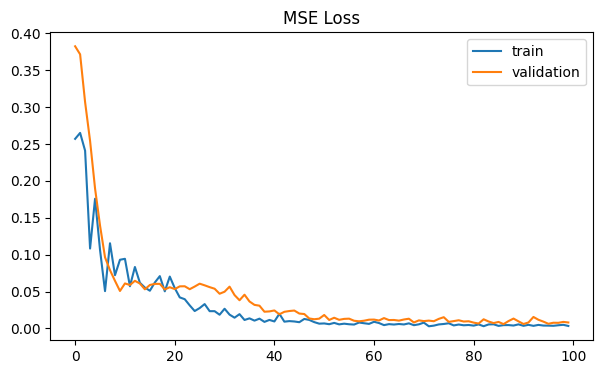

In [124]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np, label="train")
ax.plot(val_loss_np, label="validation")
plt.title("MSE Loss")
plt.legend()
plt.show()

In [125]:
best_train_epoch, best_val_epoch

(71, 86)

In [126]:
min_plot = best_val_epoch-10 if best_val_epoch >= 10 else 0
max_plot = best_val_epoch+10

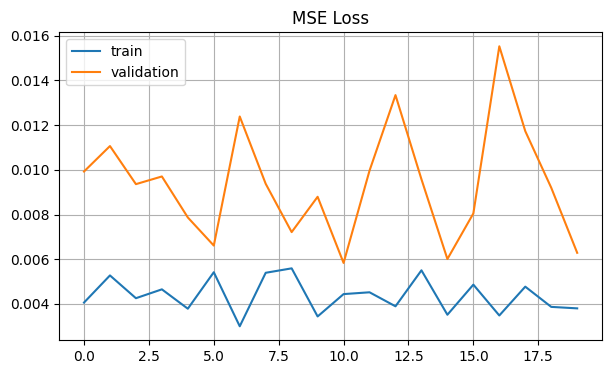

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss_np[min_plot:max_plot], label="train")
ax.plot(val_loss_np[min_plot:max_plot], label = "validation")
plt.title("MSE Loss")
plt.grid(which='both')
plt.legend()
plt.show()

## Testing

### Load Data

In [128]:
def make_dataloader(data, input_step, predict_step, batch_size=1):
    dataset = Dataset(data, input_step, predict_step)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, dataloader

In [129]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(precision=5, suppress=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
test_set, test_loader = make_dataloader(test, input_step, predict_step, batch_size=600)
all_data = test_set.data[:,0]

In [131]:
test_set.data.shape

(60, 10)

In [132]:
test.size

600

### Load Model and State

In [133]:
epoch_num = best_val_epoch
print(epoch_num)
par_path = os.path.join(model_path, "best_val_loss_model.model")

86


In [134]:
net = Transformer(device, d_model, in_dim, N_enc, N_dec, h_enc, h_dec, ff_hidnum, hid_pre, hid_post, dropout_pre, dropout_post, dropout_model, norm_first)
    
# load parameter
if device == torch.device("cpu"):
  net.load_state_dict(torch.load(par_path, map_location=torch.device("cpu")))
else:
  net.load_state_dict(torch.load(par_path,map_location=torch.device(device)))

### Testing Process

In [135]:
net.eval()

pred_list = np.zeros((1, predict_step))
for iters, (x, y, tgt) in enumerate(test_loader):
    tgt = tgt[:,:,0]

    out = net.generate(x, tgt.shape[1], y[:,[0],:],multi)
    if multi:
        out = out[:,:,0].to('cpu').detach().numpy().copy()
    else:
        out = out.to('cpu').detach().numpy().copy()

    pred_list = np.concatenate([pred_list, out], axis=0)

pred_list = pred_list[1:]
D = []
for i in range(predict_step):
    tmp = np.concatenate([all_data[:(input_step+i)], pred_list[:,i], all_data[(all_data.shape[0]-(predict_step - (i + 1))):]])
    D.append(tmp)

for step_num, tmp_data in enumerate(D):
    n = step_num + 1

    np.save(os.path.join(test_result_path, "pred{}_epoch{}".format(n, epoch_num)), pred_list[:,[step_num]])
    np.save(os.path.join(test_result_path, "tgt{}_epoch{}".format(n, epoch_num)), tgt[:,[step_num]])

### Plot Testing

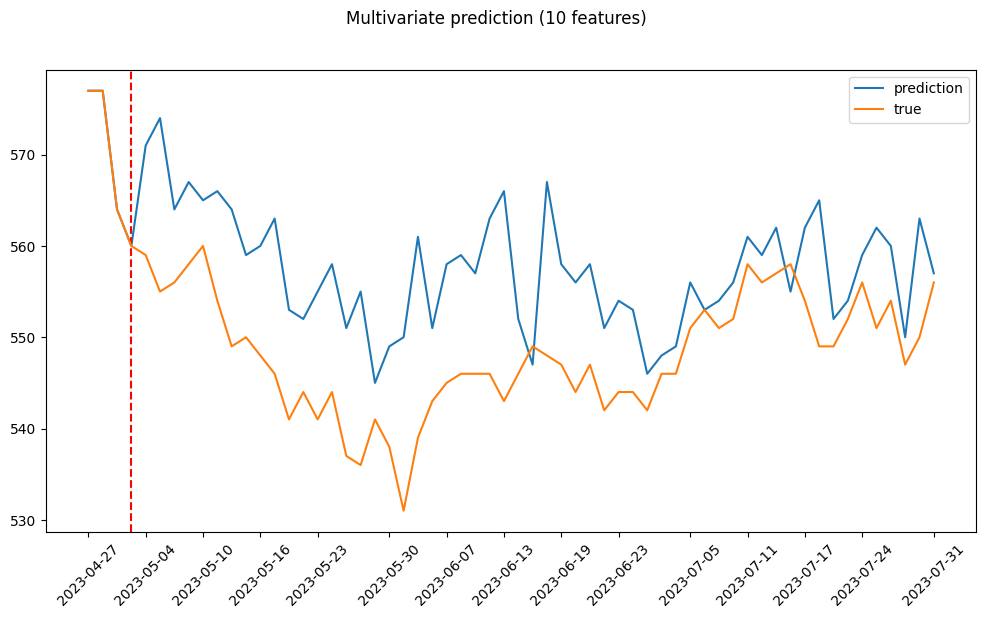

In [136]:
all_data_denorm = np.round(scaler.inverse_transform(all_data.reshape(all_data.size,1)))
fig, (ax1) = plt.subplots(1, 1,figsize=(12,6), sharex=True, sharey=True)
indeks = original.index[-60:]
fig.suptitle(f'Multivariate prediction ({in_dim} features)')
for i,C in enumerate(D):
  d_denorm = np.round(scaler.inverse_transform(C.reshape(C.size,1)))
  ax1.plot(d_denorm, label='prediction')
ax1.axvline(input_step-1, ls='dashed', c='r')
ax1.plot(all_data_denorm, label='true')
ax1.legend()
num_ticks = 15 
x_ticks = np.linspace(0, len(indeks) - 1, num_ticks, dtype=int)
x_labels = indeks[x_ticks].strftime('%Y-%m-%d')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels, rotation=45)
#plt.savefig('Grad-CAM/Multivariate prediction ({in_dim} features).jpg')
plt.show()

### Error

In [137]:
MAPE = []
for ind, d in enumerate(D):
    d_denorm = np.round(scaler.inverse_transform(d.reshape(d.size,1)))
    print(f"Error Pred {ind+1}")
    print(f"MAPE\t : {np.round(mean_absolute_percentage_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])*100,5)}")
    print(f"MAE\t : {np.round(mean_absolute_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:]),5)}")
    print(f"MSE\t : {np.round(mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:]),5)}")
    print(f"RMSE\t : {np.round(np.sqrt(mean_squared_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])),5)}\n")
    MAPE.append(np.round(mean_absolute_percentage_error(all_data_denorm[input_step+ind:], d_denorm[input_step+ind:])*100,5))
print("Rata-rata MAPE ",np.round(np.mean(MAPE),5))

Error Pred 1
MAPE	 : 1.73275
MAE	 : 9.46429
MSE	 : 123.14286
RMSE	 : 11.09698

Rata-rata MAPE  1.73275


# LSTM

## Model

In [165]:
class LSTM(nn.Module):

    def __init__(self, input_size, num_classes, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Dataset

In [166]:
def load_data(data_path,multivariate=False,in_dim=1):
    data = pd.read_csv(data_path)

    data.date = pd.to_datetime(data.date)

    data = data.set_index('date')
    data_len = data.shape[0]
    numpy_use_jii = data['jii'].to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    numpy_use_jii = scaler.fit_transform(numpy_use_jii.reshape(-1,1))
    if multivariate:
        if in_dim == 10:
            data = data[['jii', 'vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 36:
            data = data.drop(columns=['vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 41:
            data = data.drop(columns=['new_cases', 'new_cases_smoothed', 'new_cases_per_million','new_cases_smoothed_per_million'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 45:
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        return numpy_use, scaler, original_data
    else:
        original_data = data["jii"]
        return numpy_use_jii, scaler, original_data

### Load Data

In [167]:
multi = True
in_dim = 10
data, scaler, original = load_data('Data/data.csv', multivariate=multi,in_dim=in_dim)

In [168]:
data.size

8260

In [169]:
data.shape

(826, 10)

In [170]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


seq_length = 4
x, y = sliding_windows(data, seq_length)

test_size = 60
train_size = int(len(y) - test_size)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [171]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([761, 4, 10]),
 torch.Size([761, 10]),
 torch.Size([60, 4, 10]),
 torch.Size([60, 10]))

## Training

In [172]:
num_epochs = 100
learning_rate = 0.01
input_size = in_dim
hidden_size = 12
num_layers = 1

num_classes = in_dim

lstm = LSTM(input_size, num_classes, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, betas=(0.9,0.98))

start_time = time.time()

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    loss = criterion(outputs[:,0], trainY[:,0])
    
    loss.backward()
    
    optimizer.step()
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
end_time = time.time()
elapsed_time = end_time - start_time

print("Training time: {:.2f} seconds".format(elapsed_time))

Epoch: 0, loss: 0.14404
Epoch: 1, loss: 0.10353
Epoch: 2, loss: 0.07790
Epoch: 3, loss: 0.06610
Epoch: 4, loss: 0.06259
Epoch: 5, loss: 0.06028
Epoch: 6, loss: 0.05588
Epoch: 7, loss: 0.04996
Epoch: 8, loss: 0.04442
Epoch: 9, loss: 0.04073
Epoch: 10, loss: 0.03932
Epoch: 11, loss: 0.03941
Epoch: 12, loss: 0.03958
Epoch: 13, loss: 0.03872
Epoch: 14, loss: 0.03663
Epoch: 15, loss: 0.03388
Epoch: 16, loss: 0.03122
Epoch: 17, loss: 0.02920
Epoch: 18, loss: 0.02787
Epoch: 19, loss: 0.02683
Epoch: 20, loss: 0.02558
Epoch: 21, loss: 0.02388
Epoch: 22, loss: 0.02188
Epoch: 23, loss: 0.01995
Epoch: 24, loss: 0.01841
Epoch: 25, loss: 0.01725
Epoch: 26, loss: 0.01619
Epoch: 27, loss: 0.01484
Epoch: 28, loss: 0.01308
Epoch: 29, loss: 0.01114
Epoch: 30, loss: 0.00944
Epoch: 31, loss: 0.00820
Epoch: 32, loss: 0.00725
Epoch: 33, loss: 0.00625
Epoch: 34, loss: 0.00533
Epoch: 35, loss: 0.00504
Epoch: 36, loss: 0.00530
Epoch: 37, loss: 0.00538
Epoch: 38, loss: 0.00526
Epoch: 39, loss: 0.00551
Epoch: 40,

## Testing

In [173]:
testX.shape

torch.Size([60, 4, 10])

In [174]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = np.round(scaler.inverse_transform(data_predict))
#np.savetxt('data_predict.csv', data_predict, delimiter=',')

dataY_plot = np.round(scaler.inverse_transform(dataY_plot))
#np.savetxt('dataY_plot.csv', dataY_plot, delimiter=',')

In [175]:
data_predict.shape

(60, 10)

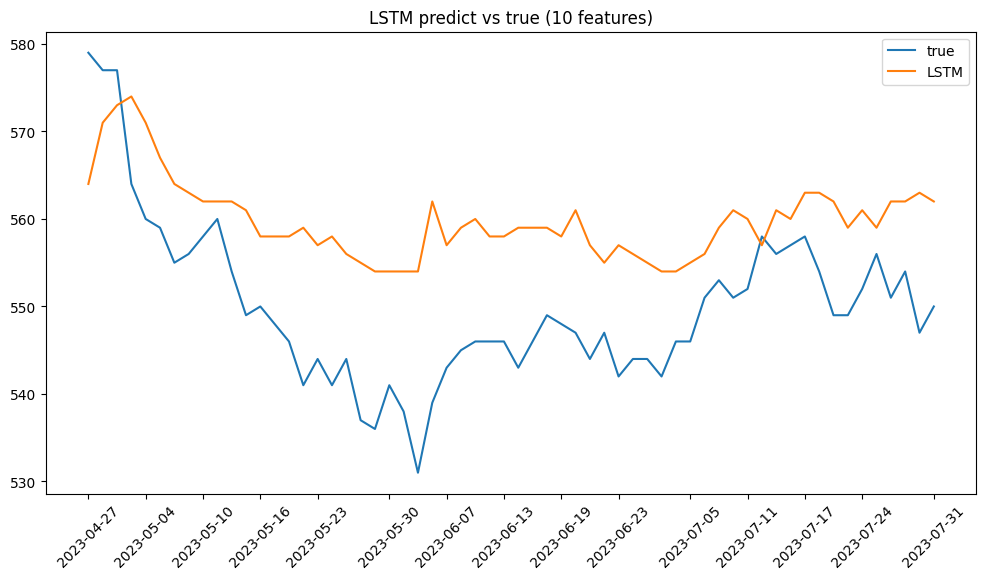

In [176]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True, sharey=True)
ax.plot(dataY_plot[:,0], label="true")
ax.plot(data_predict[:,0], label="LSTM")
indeks = original.index[-60:]
nama = f"LSTM predict vs true ({in_dim} features)"
plt.title(nama)
num_ticks = 15 
x_ticks = np.linspace(0, len(indeks) - 1, num_ticks, dtype=int)
x_labels = indeks[x_ticks].strftime('%Y-%m-%d')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)
plt.legend()
#plt.savefig(f'LSTM/{nama}.jpg') 
plt.show()

## Error

In [177]:
print(f"Error Pred")
print(f"MAPE\t : {np.round(mean_absolute_percentage_error(data_predict[:,0], dataY_plot[:,0])*100,5)}")
print(f"MAE\t : {np.round(mean_absolute_error(data_predict[:,0], dataY_plot[:,0]),5)}")
print(f"MSE\t : {np.round(mean_squared_error(data_predict[:,0], dataY_plot[:,0]),5)}")
print(f"RMSE\t : {np.round(np.sqrt(mean_squared_error(data_predict[:,0], dataY_plot[:,0])),5)}\n")

Error Pred
MAPE	 : 1.93109
MAE	 : 10.800000190734863
MSE	 : 138.39999389648438
RMSE	 : 11.764349937438965



# RNN

## Model

In [178]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_dim, layer_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :]) 

        return out

## Dataset

In [179]:
def load_data(data_path,multivariate=False,in_dim=1):
    data = pd.read_csv(data_path)

    data.date = pd.to_datetime(data.date)

    data = data.set_index('date')
    data_len = data.shape[0]
    numpy_use_jii = data['jii'].to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    numpy_use_jii = scaler.fit_transform(numpy_use_jii.reshape(-1,1))
    if multivariate:
        if in_dim == 10:
            data = data[['jii', 'vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu']]
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 36:
            data = data.drop(columns=['vol jii', 'ihsg', 'vol ihsg', 'usd', 'eur', 'gold/gr', 'silver/gr', 'oil/bbl', 'gas/mmbtu'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        elif in_dim == 41:
            data = data.drop(columns=['new_cases', 'new_cases_smoothed', 'new_cases_per_million','new_cases_smoothed_per_million'])
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        if in_dim == 45:
            numpy_use = data.to_numpy()
            original_data = data
            scaler_all = MinMaxScaler(feature_range=(-1, 1)) 
            numpy_use = scaler_all.fit_transform(numpy_use)
        return numpy_use, scaler, original_data
    else:
        original_data = data["jii"]
        return numpy_use_jii, scaler, original_data

### Load Data

In [180]:
data, scaler, original = load_data('Data/data.csv', multivariate=multi,in_dim=in_dim)

In [181]:
data.size

8260

In [182]:
data.shape

(826, 10)

In [183]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

seq_length = 4
x, y = sliding_windows(data, seq_length)

test_size = 60
train_size = int(len(y) - test_size)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [184]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([761, 4, 10]),
 torch.Size([761, 10]),
 torch.Size([60, 4, 10]),
 torch.Size([60, 10]))

## Training

In [185]:
num_epochs = 100
learning_rate = 0.01

input_size = in_dim
hidden_size = 12
num_layers = 1

num_classes = in_dim

rnn = RNN(input_size, num_classes, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, betas=(0.9,0.98))

start_time = time.time()
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs[:,0], trainY[:,0])
    
    loss.backward()
    
    optimizer.step()
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
end_time = time.time()
elapsed_time = end_time - start_time

print("Training time: {:.2f} seconds".format(elapsed_time))

Epoch: 0, loss: 0.12034
Epoch: 1, loss: 0.10707
Epoch: 2, loss: 0.09619
Epoch: 3, loss: 0.08621
Epoch: 4, loss: 0.07638
Epoch: 5, loss: 0.06669
Epoch: 6, loss: 0.05752
Epoch: 7, loss: 0.04972
Epoch: 8, loss: 0.04462
Epoch: 9, loss: 0.04354
Epoch: 10, loss: 0.04497
Epoch: 11, loss: 0.04424
Epoch: 12, loss: 0.04100
Epoch: 13, loss: 0.03691
Epoch: 14, loss: 0.03290
Epoch: 15, loss: 0.02929
Epoch: 16, loss: 0.02619
Epoch: 17, loss: 0.02360
Epoch: 18, loss: 0.02163
Epoch: 19, loss: 0.02004
Epoch: 20, loss: 0.01852
Epoch: 21, loss: 0.01691
Epoch: 22, loss: 0.01522
Epoch: 23, loss: 0.01343
Epoch: 24, loss: 0.01156
Epoch: 25, loss: 0.00978
Epoch: 26, loss: 0.00853
Epoch: 27, loss: 0.00763
Epoch: 28, loss: 0.00681
Epoch: 29, loss: 0.00641
Epoch: 30, loss: 0.00615
Epoch: 31, loss: 0.00592
Epoch: 32, loss: 0.00591
Epoch: 33, loss: 0.00590
Epoch: 34, loss: 0.00590
Epoch: 35, loss: 0.00596
Epoch: 36, loss: 0.00597
Epoch: 37, loss: 0.00597
Epoch: 38, loss: 0.00592
Epoch: 39, loss: 0.00571
Epoch: 40,

## Testing

In [186]:
testX.shape

torch.Size([60, 4, 10])

In [187]:
rnn.eval()
train_predict = rnn(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = np.round(scaler.inverse_transform(data_predict))
#np.savetxt('data_predict.csv', data_predict, delimiter=',')

dataY_plot = np.round(scaler.inverse_transform(dataY_plot))
#np.savetxt('dataY_plot.csv', dataY_plot, delimiter=',')

In [188]:
data_predict.shape

(60, 10)

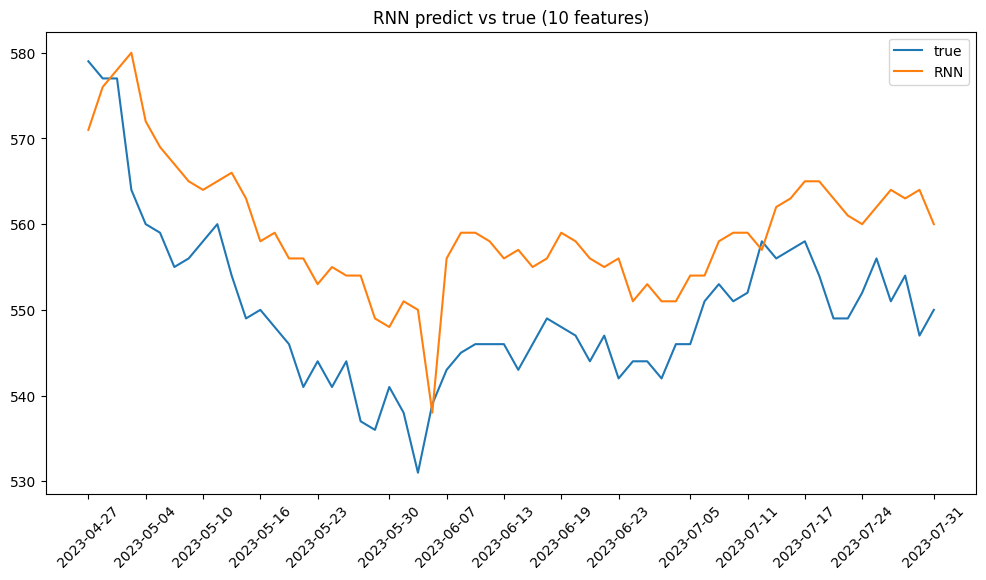

In [189]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True, sharey=True)
ax.plot(dataY_plot[:,0], label="true")
ax.plot(data_predict[:,0], label="RNN")
indeks = original.index[-60:]
nama = f"RNN predict vs true ({in_dim} features)"
plt.title(nama)
num_ticks = 15 
x_ticks = np.linspace(0, len(indeks) - 1, num_ticks, dtype=int)
x_labels = indeks[x_ticks].strftime('%Y-%m-%d')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45)
plt.legend()
#plt.savefig(f'RNN/{nama}.jpg') 
plt.show()

## Error

In [190]:
print(f"Error Pred")
print(f"MAPE\t : {np.round(mean_absolute_percentage_error(data_predict, dataY_plot)*100,5)}")
print(f"MAE\t : {mean_absolute_error(data_predict, dataY_plot)}")
print(f"MSE\t : {mean_squared_error(data_predict, dataY_plot)}")
print(f"RMSE\t : {np.sqrt(mean_squared_error(data_predict, dataY_plot))}\n")

Error Pred
MAPE	 : 9.89317
MAE	 : 52.75
MSE	 : 4397.14990234375
RMSE	 : 66.3110122680664

